In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

plt.style.use('ggplot')
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore")

In [101]:
df = pd.read_csv("data/churn_dataset.csv")

In [102]:
df.shape

(38674, 69)

In [103]:
df.head().T

,0,1,2,3,4
customer_db_id,54478736d4cde82247f1345f,54478fa4d3cde8d17ca5e4db,5447eefcd3cde8cf7ca5e4eb,5447f1a2d4cde82147f1347d,544976fad4cde8f3415bedb0
customer_id,GB-CUS-Y8922200,GB-CUS-K3854440,GB-CUS-L2277081,GB-CUS-C3589820,GB-CUS-P7798401
gender,male,female,male,male,male
segment,NaN,RED,NaN,NaN,NaN
aov,NaN,10.1501,NaN,NaN,NaN
recency,1370,1211,1370,1370,1190
frequency,0,0,0,0,0
churn_factor,1,1,1,1,1
referred,False,False,False,False,False
newsletter_optin,False,False,False,False,False


# Fill NA values

In [104]:
nans = df.isnull().sum()
nans[nans > 0].sort_values(ascending = False)

refunds_unsuccess              38640
refunds_success                38047
rating_diff                    33028
last_order_rating              33028
first_order_rating             30712
first_order_fac_name           26042
avg_rating                     25630
last_order_voucher_channel     23130
last_order_fac_name            20756
first_order_voucher_channel    19930
first_order_products           10837
last_order_hub_distance         5803
first_order_hub_distance        5738
avg_hub_distance                4696
aov                             4124
segment                         4124
gender                          1114
zip_area                         588
zip                              475
dtype: int64

In [105]:
df['first_order_products'] = df['first_order_products'].fillna("")

In [106]:
df[['refunds_unsuccess', 'refunds_success']] = df[['refunds_unsuccess', 'refunds_success']].fillna(0)

In [107]:
rating_cols = ['avg_rating', 'rating_diff', 'last_order_rating', 'rated_orders', 'first_order_rating']
df[rating_cols] = df[rating_cols].fillna(-999)
df.loc[df.rated_orders > 0, rating_cols].head()

,avg_rating,rating_diff,last_order_rating,rated_orders,first_order_rating
31,5.000000,-999.000000,-999.0,1,-999.0
33,4.961538,-999.000000,-999.0,26,-999.0
38,4.891892,-999.000000,-999.0,37,-999.0
44,3.888889,-999.000000,-999.0,9,-999.0
46,2.333333,2.666667,5.0,3,-999.0


In [108]:
df.aov = df.aov.fillna(0)
df.segment = df.segment.fillna('None')
df.gender = df.gender.fillna('Unknown')

In [109]:
df.zip = df.zip.fillna('Unknown')
df.zip_area = df.zip_area.fillna('Unknown')

df.avg_hub_distance = df.avg_hub_distance.fillna(-999)
df.last_order_hub_distance = df.last_order_hub_distance.fillna(-999)
df.first_order_hub_distance = df.first_order_hub_distance.fillna(-999)

In [110]:
nans = df.isnull().sum()
nans[nans > 0].sort_values(ascending = False)

first_order_fac_name           26042
last_order_voucher_channel     23130
last_order_fac_name            20756
first_order_voucher_channel    19930
dtype: int64

# Bad vs Good Voucher Customers
*Assumption: Bad customers are customers who had one completed order using a voucher, had a good customer experience and didn't please another order for more than a year. These customers should be excluded from churn analysis.*

We want to analyse, if there are any specific features, such as area, channels, products that identify bad customers. In order to analyse, we create a 'Good Customers' group, which are customers, who have returned after their first order with vouchers.

Bad Voucher customers: 
- First_Order_Voucher == TRUE
- Completed_Orders == 1
- Total_Orders == 1
- Last_Order > 365 days ago

Good Voucher customers:
- First_Order_Voucher == TRUE
- Completed_Orders > 1

In [143]:
def plot_bad_vs_good_by_column(column_name):
    df_bad = df_vou_bad.groupby(column_name)['customer_db_id'].nunique() / df_vou_bad.shape[0]
    df_good = df_vou_good.groupby(column_name)['customer_db_id'].nunique() / df_vou_good.shape[0]
    df_diff = df_good - df_bad
    df_diff_relative = df_diff / (df_bad + df_good)
    df = pd.concat([df_bad, df_good, df_diff, df_diff_relative], 
                  axis=1, keys=['bad', 'good', 'diff', 'diff_relative'], sort=True)
    
    df = df.sort_values('diff', ascending=False)
    df[['bad', 'good']].plot(kind='bar', title=column_name)
    df[['diff']].plot(kind='bar', title='diff (+ more good / - more bad)', color='orange')
    df[['diff_relative']].sort_values('diff_relative', ascending=False).plot(kind='bar', title='diff relative (diff / all customers)', color='orange')

In [112]:
df_vou = df.loc[df.first_order_voucher & df.valid_orders > 0]
df_vou_good = df_vou.loc[(df_vou.valid_orders > 1)]
df_vou_bad = df_vou.loc[(df_vou.valid_orders == 1) & (df_vou.total_orders == 1) & (df_vou.recency > 365)]

In [113]:
print('Number of Bad customers: ', df_vou_bad.shape[0])
print('Number of Good customers: ', df_vou_good.shape[0])

df_vou_bad['customer_type'] = 'bad'
df_vou_good['customer_type'] = 'good'
df_both = pd.concat([df_vou_bad, df_vou_good])

Number of Bad customers:  6876
Number of Good customers:  2603


## Distance to Hub 

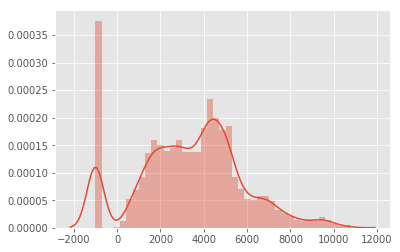

In [114]:
sns.distplot(df_both[['first_order_hub_distance']])

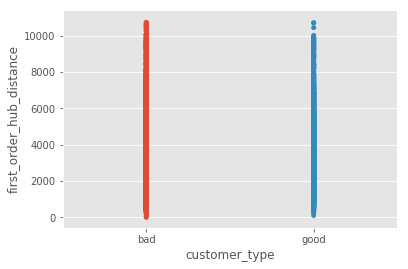

In [115]:
a = df_both.loc[df_both.first_order_hub_distance != -999, ['customer_type', 'first_order_hub_distance']]
sns.categorical.stripplot(data=a, x='customer_type', y='first_order_hub_distance')

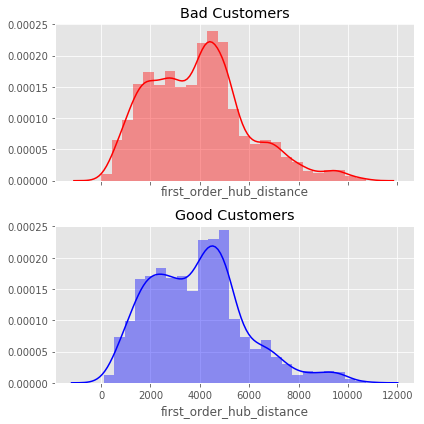

In [116]:
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True,figsize=(6,6))
sns.distplot(a.loc[a.customer_type == 'bad', 'first_order_hub_distance'], ax=ax1, color='red', bins=25)
ax1.set_title('Bad Customers')
sns.distplot(a.loc[a.customer_type == 'good', 'first_order_hub_distance'], ax=ax2, color='blue', bins=25)
ax2.set_title('Good Customers')
plt.tight_layout()

## Facility

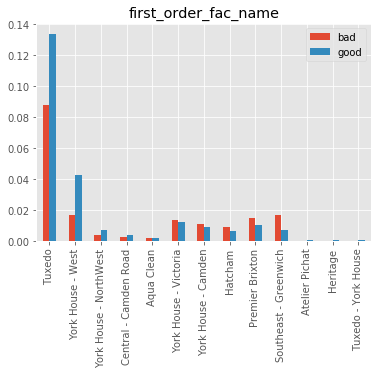

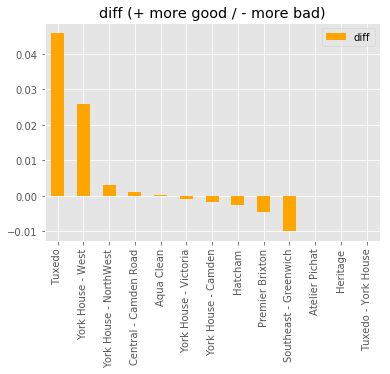

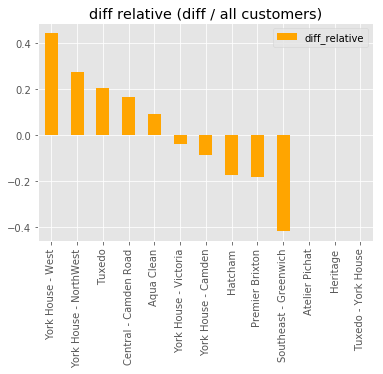

In [144]:
plot_bad_vs_good_by_column('first_order_fac_name')

## Service Class

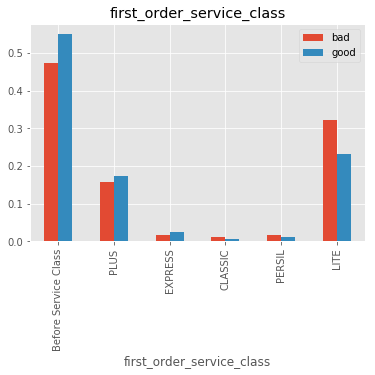

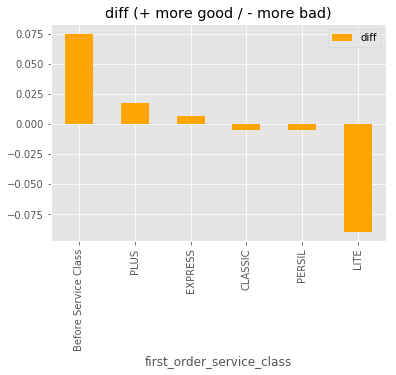

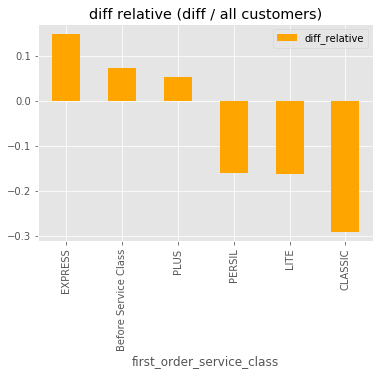

In [145]:
plot_bad_vs_good_by_column('first_order_service_class')

# Voucher Channel

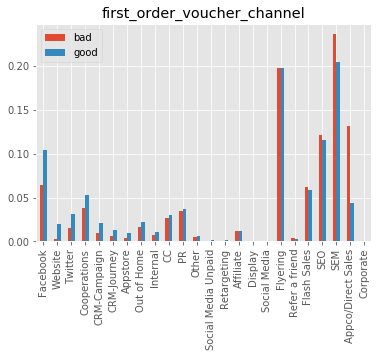

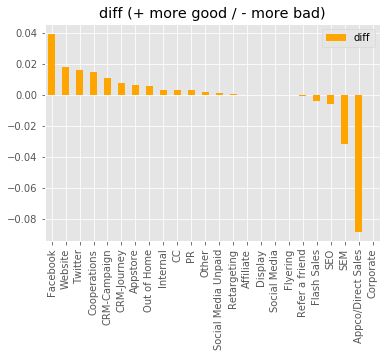

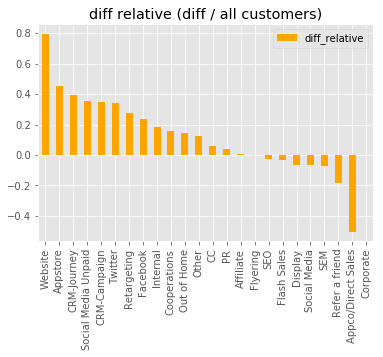

In [146]:
plot_bad_vs_good_by_column('first_order_voucher_channel')

## Gender

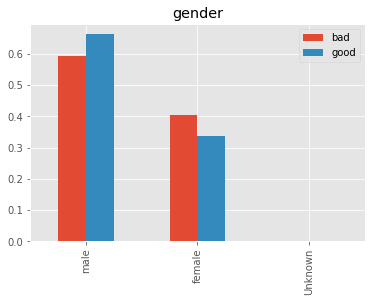

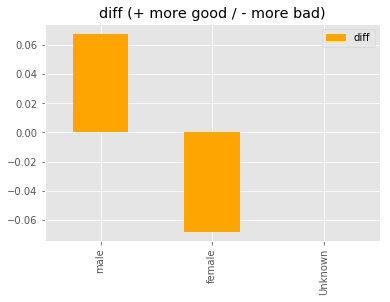

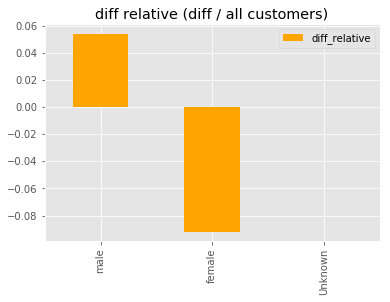

In [147]:
plot_bad_vs_good_by_column('gender')

## Zip Area

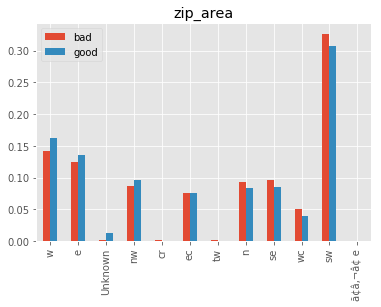

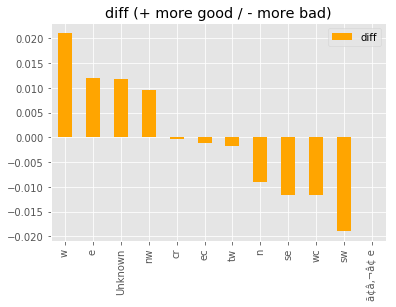

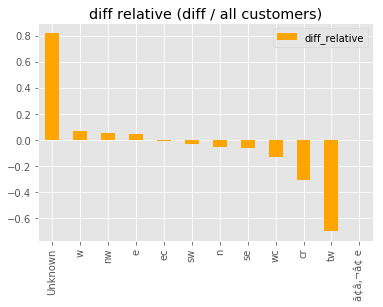

In [148]:
plot_bad_vs_good_by_column('zip_area')

## Product Segmentation

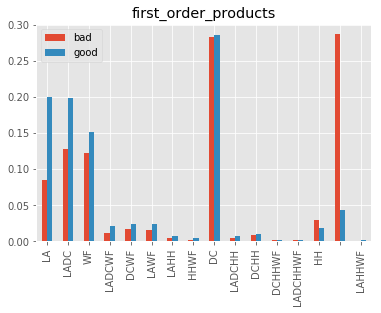

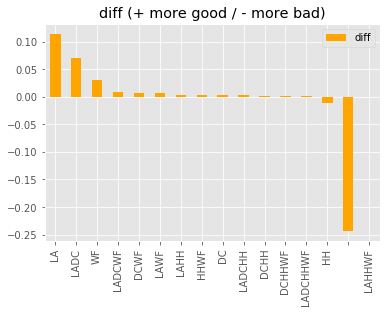

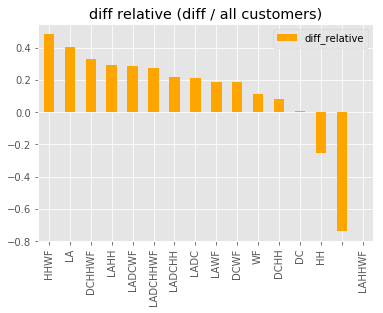

In [149]:
plot_bad_vs_good_by_column('first_order_products')

In [61]:
df_both.gender.unique()

array(['male', 'female', 'Unknown'], dtype=object)

In [62]:
df_both['gender'] = df_both['gender'].map({'male': -1, 'female': 1, 'Unknown': 0})

In [63]:
df_both['customer_type'] = df_both['customer_type'].map({'bad': -1, 'good': 1})

In [64]:
df_both.first_order_voucher_channel.unique()

array(['Internal', 'CRM-Campaign', 'CC', 'Flyering', 'Other',
       'Cooperations', 'Twitter', 'Facebook', 'Social Media Unpaid',
       'Flash Sales', 'Display', 'Out of Home', 'Appco/Direct Sales',
       'PR', 'SEM', 'Social Media', 'SEO', 'Appstore', 'Website',
       'CRM-Journey', 'Refer a friend', 'Affiliate', 'Retargeting',
       'Corporate'], dtype=object)

In [65]:
vou_channel_le = LabelEncoder()
vou_channel_le.fit(df_both.first_order_voucher_channel)
df_both['first_order_voucher_channel_enc'] = vou_channel_le.transform(df_both.first_order_voucher_channel.tolist())

In [66]:
serv_class_le = LabelEncoder()
serv_class_le.fit(df_both.first_order_service_class)
df_both['first_order_service_class_enc'] = serv_class_le.transform(df_both.first_order_service_class.tolist())

In [ ]:
products_le = LabelEncoder()
products_le.fit(df_both.first_order_products)
df_both['first_order_products_enc'] = products_le.transform(df_both.first_order_products.tolist())

In [ ]:
cor = df_both[['customer_type', 'gender', 'referred', 'newsletter_optin', 
         'product_LA', 'product_HH', 'product_DC', 'product_WF', 
         'first_order_voucher_channel_enc', 'first_order_service_class_enc', 
         'first_order_products_enc', 'avg_fac_distance']].corr()

In [ ]:
cor.loc['customer_type']

In [ ]:
sns.heatmap(cor, 
            xticklabels=cor.columns.values,
            yticklabels=cor.columns.values)